 [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/gibsonlab/mdsine2_tutorials/blob/main/notebooks/tut_02_inference.ipynb)
 # Running inference with the MDSINE2 model and exploring the posterior

In [ ]:
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    # Get data
    !curl -LJO https://github.com/gibsonlab/mdsine2_tutorials/raw/main/data/replicates-toy.zip
    !curl -LJO https://github.com/gibsonlab/mdsine2_tutorials/raw/main/data/healthy-toy.zip
    
    !mkdir -p ./data/
    !unzip -o healthy-toy.zip -d ./data/ && unzip -o replicates-toy.zip -d ./data/

    !git clone https://github.com/gerberlab/MDSINE2
    !pip install MDSINE2/.

else:
    !cd ..

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  3265  100  3265    0     0   6023      0 --:--:-- --:--:-- --:--:--  6023
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 22392  100 22392    0     0  51594      0 --:--:-- --:--:-- --:--:-- 51594
Archive:  healthy-toy.zip
   creating: ./data/healthy-toy/
  inflating: ./data/healthy-toy/perturbations.tsv  
  inflating: ./data/healthy-toy/qpcr.tsv  
  inflating: ./data/healthy-toy/metadata.tsv  
  inflating: ./data/healthy-toy/counts.tsv  
  inflating: ./data/healthy-toy/rdp_species.tsv  
Archive:  replicates-toy.zip
   creating: ./data/replicates-toy/
  infla

In [ ]:
import mdsine2 as md2
from mdsine2.names import STRNAMES
from pathlib import Path
import matplotlib.pyplot as plt 
import numpy as np 


[DEBUG] Using default logger (stdout, stderr).


 # Loading data
 Here we load a small preprocessed "toy" dataset created in the previous tutorial.

In [ ]:
data_dir = Path('./data/')
replicates_dir = data_dir / 'replicates-toy'
healthy_dir = data_dir / 'healthy-toy'

output_dir = Path('./output/')
fig_dir = Path('./figs/')

output_dir.mkdir(exist_ok=True, parents=True)
fig_dir.mkdir(exist_ok=True, parents=True)



In [ ]:
# # Read data
studies = []
for d_dir in [replicates_dir, healthy_dir]:
    tsv_files = sorted(d_dir.glob('*.tsv'))
    tsv_files = {f.stem : f for f in tsv_files}

    # Read data into study object
    study = md2.dataset.parse(
        name = d_dir.stem,
        metadata = tsv_files['metadata'],
        taxonomy = tsv_files['rdp_species'],
        reads = tsv_files['counts'],
        qpcr = tsv_files['qpcr'],
        perturbations = tsv_files['perturbations'],
    )
    studies.append(study)

replicates, healthy = studies


[INFO] TaxaSet parsng new taxonomy table. Resetting
[INFO] No `name` found - assuming index is the name
[DEBUG] Reseting perturbations
[INFO] TaxaSet parsng new taxonomy table. Resetting
[INFO] No `name` found - assuming index is the name
[DEBUG] Reseting perturbations


 # Learning the Negative Binomial dispersion parameters
 Before running the main inference loop we learn the negative binomial parameters from our physical replicates.
 Then, we build the compute graph for learning the model that is used to learn negative binomial parameters.

In [ ]:
# set negative binomial model inference parameters
params = md2.config.NegBinConfig(
    seed=0, burnin=100, n_samples=200,
    checkpoint=100, 
    basepath=str(output_dir / "negbin")
)

# Build the compute graph to learn negative binomial parameters
mcmc_negbin = md2.negbin.build_graph(
    params=params, 
    graph_name=replicates.name, 
    subjset=replicates
    )

# Run inference to learn the negative binomial parameters
mcmc_negbin = md2.negbin.run_graph(
    mcmc_negbin, 
    crash_if_error=True
)

# Print a summary of a0 and a1 posterior
print('a0', md2.summary(mcmc_negbin.graph[STRNAMES.NEGBIN_A0]))
print('a1', md2.summary(mcmc_negbin.graph[STRNAMES.NEGBIN_A1]))


[DEBUG] Available subjects: M2-D10,M2-D8,M2-D9
[DEBUG] Subject M2-D10, available qpcr: 0.0,1.0,2.0,3.0,4.0,5.0
[DEBUG] Subject M2-D8, available qpcr: 0.0,1.0,2.0,3.0,4.0,5.0
[DEBUG] Subject M2-D9, available qpcr: 0.0,1.0,2.0,3.0,4.0,5.0
[INFO] Setting Single Write, Multiple Read Mode
[INFO] Setting the trace of learned parameters
[INFO] #######################################
[INFO] Setting the trace of Negative binomial dispersion a0
[INFO] Setting the trace of Negative binomial dispersion a1
[INFO] Setting the trace of Filtering
[INFO] Setting the trace for diagnostic variables
[INFO] ##########################################
 45%|████▌     | 90/200 [00:01<00:00, 124.05it/s][DEBUG] Inference iteration 100/200, time: 1.3351476192474365
[DEBUG] Negative binomial dispersion a0: Value: 1.9598217368212737e-10, Acceptance rate: 1.0
[DEBUG] Negative binomial dispersion a1: Value: 0.0717629171067232, Acceptance rate: 0.58
[DEBUG] Filtering: no-mp : Time: 0.0031, Acc: [0.333, 0.467, 0.333], 

 Here we visualize the fit of the learned negative binomial model. This is not representative of the real results because we only have the 15 of the most abundant taxa here.

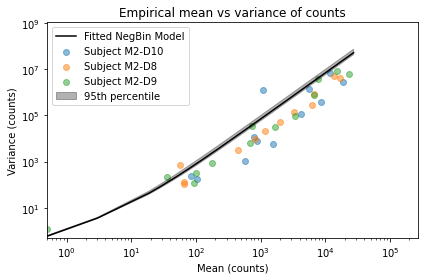

In [ ]:
fig = md2.negbin.visualize_learned_negative_binomial_model(mcmc_negbin)
fig.tight_layout()
plt.savefig(fig_dir / 'negbin_fit.png')


 # Run inference on the full model
 ### Initialize and set model hyperparameters
 Here we use the learned parameters from the negative binomial model to run inference with the full model. First, we'll create a routine that takes our mcmc object as input and plots posterior quantities.

In [ ]:
def visualize(mcmc, study, seed):
    """ Viz posteriors.
    """
    growth = mcmc.graph[STRNAMES.GROWTH_VALUE]
    growth_rates_trace = growth.get_trace_from_disk(section='entire')

    growth_rates_mean = md2.summary(growth)['mean']
    print('Mean growth rates for taxa over posterior', growth_rates_mean)

    # Visualize trace for the first taxa
    md2.visualization.render_trace(growth_rates_trace[:,0], n_burnin=50, **{'title': 'OTU_1 Growth rate'})
    plt.savefig(fig_dir / 'posterior_growth_rates_{:04d}.png'.format(seed))

    # Process variance
    processvar = mcmc.graph[STRNAMES.PROCESSVAR]
    pv_rates_trace = processvar.get_trace_from_disk(section='entire')

    md2.visualization.render_trace(pv_rates_trace, n_burnin=50, **{'title': 'process variance'})
    plt.savefig(fig_dir / 'posterior_process_variance_{:04d}.png'.format(seed))

    # Taxa module assignments
    clustering = mcmc.graph[STRNAMES.CLUSTERING_OBJ]
    md2.generate_cluster_assignments_posthoc(clustering, set_as_value=True)
    taxa = mcmc.graph.data.taxa

    # Create an order
    members = [list(x.members) for x in mcmc.graph[STRNAMES.CLUSTERING_OBJ]]
    members = [item for sublist in members for item in sublist]

    # Visualize co-cluster posterior probability
    coclusters = md2.summary(mcmc.graph[STRNAMES.CLUSTERING_OBJ].coclusters)['mean']
    md2.visualization.render_cocluster_probabilities(coclusters, taxa=study.taxa,
        yticklabels='%(paperformat)s | %(index)s', order=members)
    plt.savefig(fig_dir / 'posterior_cocluster_probs_{:04d}.png'.format(seed))

    # Visualize trace for number of modules
    md2.visualization.render_trace(clustering.n_clusters)
    plt.savefig(fig_dir / 'posterior_num_modules_trace_{:04d}.png'.format(seed))



 Here we run inference, iterate through different seed values.

[INFO] max_value found: 551243918704.4608, scaling_factor: 1.8140789695244354e-10
[INFO] Normalizing abundances for a max value of 100. Normalization constant: 1.8141E-10
[INFO] There are 305 qPCR measurements for 3 buckets. Each bucket is 101 measurements long
[INFO] Initializing Filtering
[INFO] Setting up the essential timepoints
[INFO] Essential timepoints: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   6.   7.   8.
  9.  10.  11.  14.  16.  18.  21.  21.5 22.  22.5 23.  23.5 24.  25.
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  33.  35.  35.5 36.  36.5
 37.  37.5 38.  39.  42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  47.
 50.  50.5 51.  51.5 52.  52.5 53.  54.  57.  57.5 58.  58.5 59.  59.5
 60.  60.5 61.  62.  63.  64.  64.5]
[INFO] Initializing Zero inflation


[WARNING] `zero_inflation_transition_policy` is None so we are not doing anything


[INFO] Initializing LHS vector
[INFO] Initializing growth design matrix
[INFO] Initializing self-interactions design matrix
[INFO] Initializing Clustering concentration parameter
[INFO] Cluster Concentration initialization results:
	prior shape: 1e-05
	prior scale: 100000.0
	value: 1.0
[INFO] Initializing Clustering parameter
[INFO] Cluster Assingments initialization results:
Clustering object (contains ability to change the cluster assignments), n_clusters: 15
Cluster 100115
	members: ['ASV_1']
	size: 1
Cluster 100116
	members: ['ASV_2']
	size: 1
Cluster 100117
	members: ['ASV_3']
	size: 1
Cluster 100118
	members: ['ASV_4']
	size: 1
Cluster 100119
	members: ['ASV_5']
	size: 1
Cluster 100120
	members: ['ASV_6']
	size: 1
Cluster 100121
	members: ['ASV_7']
	size: 1
Cluster 100122
	members: ['ASV_8']
	size: 1
Cluster 100123
	members: ['ASV_9']
	size: 1
Cluster 100124
	members: ['ASV_10']
	size: 1
Cluster 100125
	members: ['ASV_11']
	size: 1
Cluster 100126
	members: ['ASV_12']
	size: 1
Clu

[ERROR] 25th percentile failed
[ERROR] 75th percentile failed


[INFO] Number of clusters: 4
[INFO] Clusters assigned: [1 0 0 2 1 2 3 1 1 1 1 1 1 0 2]


[ERROR] 25th percentile failed
[ERROR] 75th percentile failed


[INFO] max_value found: 551243918704.4608, scaling_factor: 1.8140789695244354e-10
[INFO] Normalizing abundances for a max value of 100. Normalization constant: 1.8141E-10
[INFO] There are 305 qPCR measurements for 3 buckets. Each bucket is 101 measurements long
[INFO] Initializing Filtering
[INFO] Setting up the essential timepoints
[INFO] Essential timepoints: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   6.   7.   8.
  9.  10.  11.  14.  16.  18.  21.  21.5 22.  22.5 23.  23.5 24.  25.
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  33.  35.  35.5 36.  36.5
 37.  37.5 38.  39.  42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  47.
 50.  50.5 51.  51.5 52.  52.5 53.  54.  57.  57.5 58.  58.5 59.  59.5
 60.  60.5 61.  62.  63.  64.  64.5]
[INFO] Initializing Zero inflation


[WARNING] `zero_inflation_transition_policy` is None so we are not doing anything


[INFO] Initializing LHS vector
[INFO] Initializing growth design matrix
[INFO] Initializing self-interactions design matrix
[INFO] Initializing Clustering concentration parameter
[INFO] Cluster Concentration initialization results:
	prior shape: 1e-05
	prior scale: 100000.0
	value: 1.0
[INFO] Initializing Clustering parameter
[INFO] Cluster Assingments initialization results:
Clustering object (contains ability to change the cluster assignments), n_clusters: 15
Cluster 100115
	members: ['ASV_1']
	size: 1
Cluster 100116
	members: ['ASV_2']
	size: 1
Cluster 100117
	members: ['ASV_3']
	size: 1
Cluster 100118
	members: ['ASV_4']
	size: 1
Cluster 100119
	members: ['ASV_5']
	size: 1
Cluster 100120
	members: ['ASV_6']
	size: 1
Cluster 100121
	members: ['ASV_7']
	size: 1
Cluster 100122
	members: ['ASV_8']
	size: 1
Cluster 100123
	members: ['ASV_9']
	size: 1
Cluster 100124
	members: ['ASV_10']
	size: 1
Cluster 100125
	members: ['ASV_11']
	size: 1
Cluster 100126
	members: ['ASV_12']
	size: 1
Clu

[ERROR] 25th percentile failed
[ERROR] 75th percentile failed


[INFO] Number of clusters: 2
[INFO] Clusters assigned: [0 0 0 0 1 0 0 1 1 1 0 0 1 0 0]


[ERROR] 25th percentile failed
[ERROR] 75th percentile failed


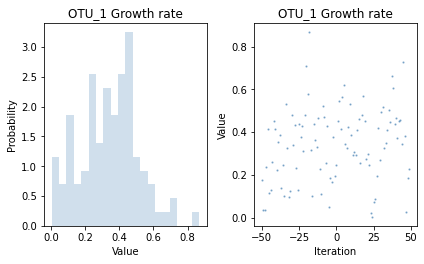

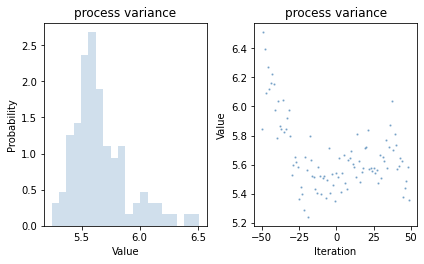

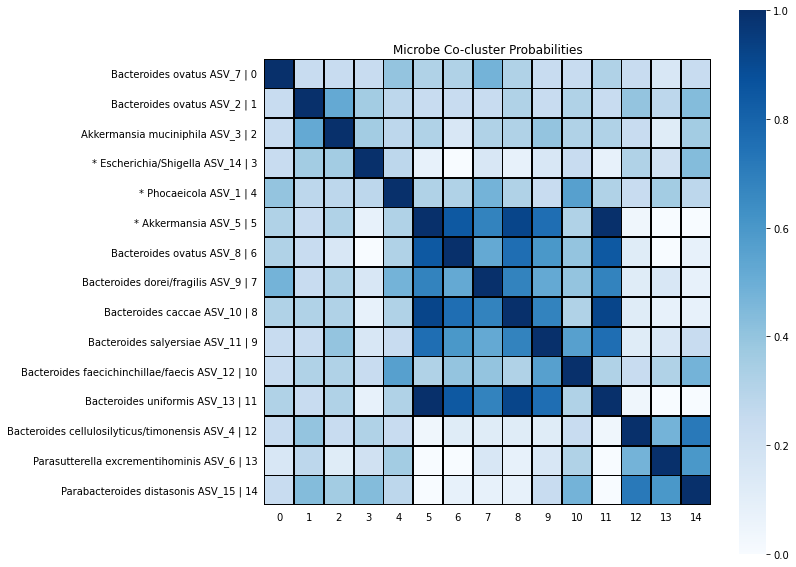

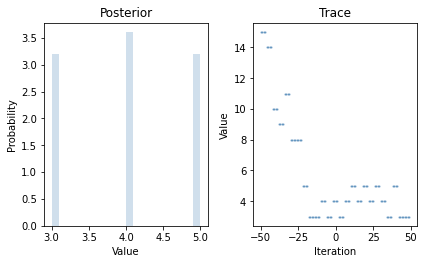

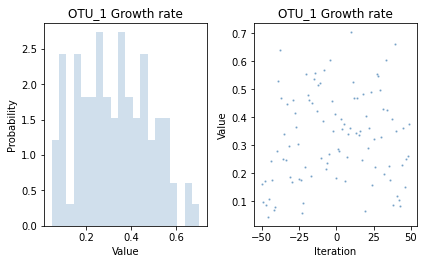

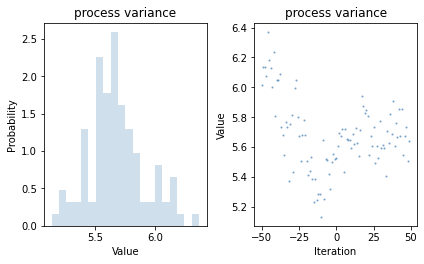

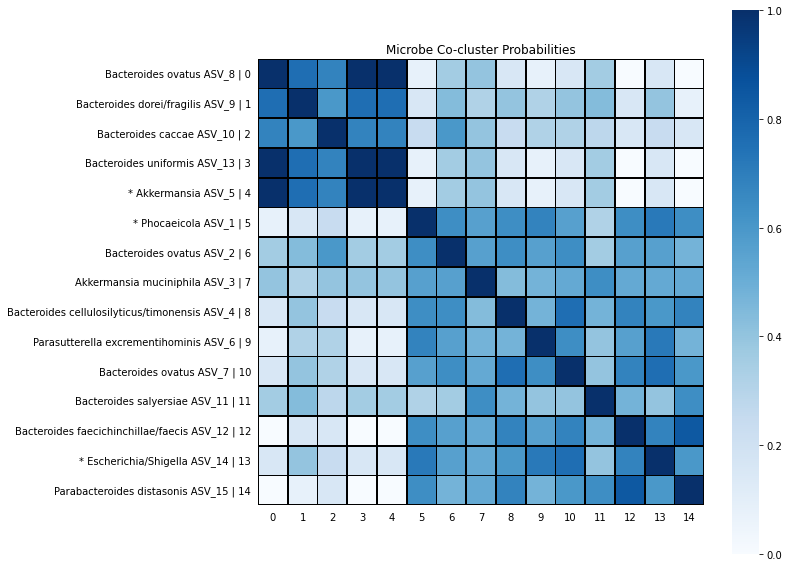

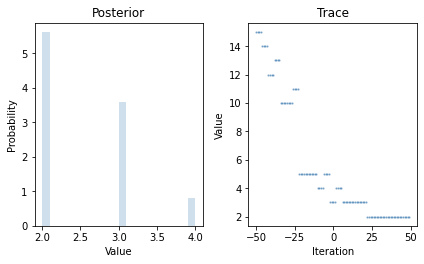

In [ ]:
# Get a0 and a1 from negbin (get the mean of the posterior) and fixes them for inference
a0 = md2.summary(mcmc_negbin.graph[STRNAMES.NEGBIN_A0])['mean']
a1 = md2.summary(mcmc_negbin.graph[STRNAMES.NEGBIN_A1])['mean']

# Save a0 and a1 for next tutorial
np.savez(data_dir / 'negbin_params.npz', a0=a0, a1=a1)

seeds = [0,]
chains = []

for seed in seeds:
    chain_basepath = output_dir / "mdsine2" / (healthy.name + "{:04d}".format(seed))
    chain_basepath.mkdir(exist_ok=True, parents=True)

    # Initialize parameters of the model 
    params = md2.config.MDSINE2ModelConfig(
        basepath=str(chain_basepath), 
        seed=seed,
        burnin=50, 
        n_samples=100, 
        negbin_a0=a0, negbin_a1=a1, 
        checkpoint=50
    )

    # The default number of modules is 30, which is larger than the number of taxa
    # that we have in this dataset, which would throw a flag.
    params.INITIALIZATION_KWARGS[STRNAMES.CLUSTERING]['value_option'] = 'no-clusters'

    # Initilize the graph
    mcmc = md2.initialize_graph(params=params, graph_name=healthy.name, subjset=healthy)

    # Perform inference
    mcmc = md2.run_graph(mcmc, crash_if_error=True)

    visualize(mcmc, healthy, seed)
    chains.append(mcmc)


In [ ]:
start = 10
end = 20
vname = STRNAMES.GROWTH_VALUE

rhat = md2.pylab.inference.r_hat(chains, start=start, end=end, vname=vname)
print('Growth parameter r-hat:', rhat)

vname = STRNAMES.CONCENTRATION
rhat = md2.pylab.inference.r_hat(chains, start=start, end=end, vname=vname)
print('Concentration parameter r-hat:', rhat)

vname = STRNAMES.PROCESSVAR
rhat = md2.pylab.inference.r_hat(chains, start=start, end=end, vname=vname)
print('Process variance parameter r-hat:', rhat)


Growth parameter r-hat: [1.3024079  1.12445614 1.13815919 1.26060763 1.01517965 2.30267948
 1.15960078 0.98702281 0.9759982  0.97307537 1.31824091 0.97838924
 1.0283582  1.55207946 1.63371716]
Concentration parameter r-hat: [1.98725417]
Process variance parameter r-hat: [2.01244564]


In [ ]:
# Consennss clustering
basepath = output_dir / 'mdsine2-fixed-cluster'
basepath.mkdir(exist_ok=True)

# Use the clustering from a previous as the clustering assignment
params = md2.config.MDSINE2ModelConfig(
    basepath=basepath, seed=0, burnin=50, n_samples=100, 
    negbin_a0=a0, negbin_a1=a1, checkpoint=50)

# Do not learn the clustering parameters
params.LEARN[STRNAMES.CLUSTERING] = False
params.LEARN[STRNAMES.CONCENTRATION] = False

# Set the initialization option for clustering
params.INITIALIZATION_KWARGS[STRNAMES.CLUSTERING]['value_option'] = 'fixed-clustering'
params.INITIALIZATION_KWARGS[STRNAMES.CLUSTERING]['value'] = str(chain_basepath / "mcmc.pkl")

mcmc = md2.initialize_graph(params=params, graph_name=healthy.name, subjset=healthy)
mcmc = md2.run_graph(mcmc, crash_if_error=True)


[INFO] max_value found: 551243918704.4608, scaling_factor: 1.8140789695244354e-10
[INFO] Normalizing abundances for a max value of 100. Normalization constant: 1.8141E-10
[INFO] There are 305 qPCR measurements for 3 buckets. Each bucket is 101 measurements long
[INFO] Initializing Filtering
[INFO] Setting up the essential timepoints
[INFO] Essential timepoints: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   6.   7.   8.
  9.  10.  11.  14.  16.  18.  21.  21.5 22.  22.5 23.  23.5 24.  25.
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  33.  35.  35.5 36.  36.5
 37.  37.5 38.  39.  42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  47.
 50.  50.5 51.  51.5 52.  52.5 53.  54.  57.  57.5 58.  58.5 59.  59.5
 60.  60.5 61.  62.  63.  64.  64.5]
[INFO] Initializing Zero inflation


[WARNING] `zero_inflation_transition_policy` is None so we are not doing anything


[INFO] Initializing LHS vector
[INFO] Initializing growth design matrix
[INFO] Initializing self-interactions design matrix
[INFO] Initializing Clustering concentration parameter
[INFO] Cluster Concentration initialization results:
	prior shape: 1e-05
	prior scale: 100000.0
	value: 1.0
[INFO] Initializing Clustering parameter
[INFO] Fixed topology initialization


[ERROR] 25th percentile failed
[ERROR] 75th percentile failed


[INFO] Number of clusters: 2
[INFO] Clusters assigned: [0 0 0 0 1 0 0 1 1 1 0 0 1 0 0]
[INFO] Clustering set to:
Clustering object (contains ability to change the cluster assignments), n_clusters: 2
Cluster 100490
	members: ['ASV_1', 'ASV_2', 'ASV_3', 'ASV_4', 'ASV_6', 'ASV_7', 'ASV_11', 'ASV_12', 'ASV_14', 'ASV_15']
	size: 10
Cluster 100491
	members: ['ASV_5', 'ASV_8', 'ASV_9', 'ASV_10', 'ASV_13']
	size: 5
[INFO] Cluster Assingments initialization results:
Clustering object (contains ability to change the cluster assignments), n_clusters: 2
Cluster 100115
	members: ['ASV_1', 'ASV_2', 'ASV_3', 'ASV_4', 'ASV_6', 'ASV_7', 'ASV_11', 'ASV_12', 'ASV_14', 'ASV_15']
	size: 10
Cluster 100116
	members: ['ASV_5', 'ASV_8', 'ASV_9', 'ASV_10', 'ASV_13']
	size: 5
[INFO] Initializing Process Variance parameter
[INFO] Initializing Mean parameter for the truncated normal prior of the growth parameter
[INFO] Initializing Variance parameter for the truncated normal prior of the growth parameter
[INFO] In

[WARNING] Automatically setting xlabels as index because there are no taxa


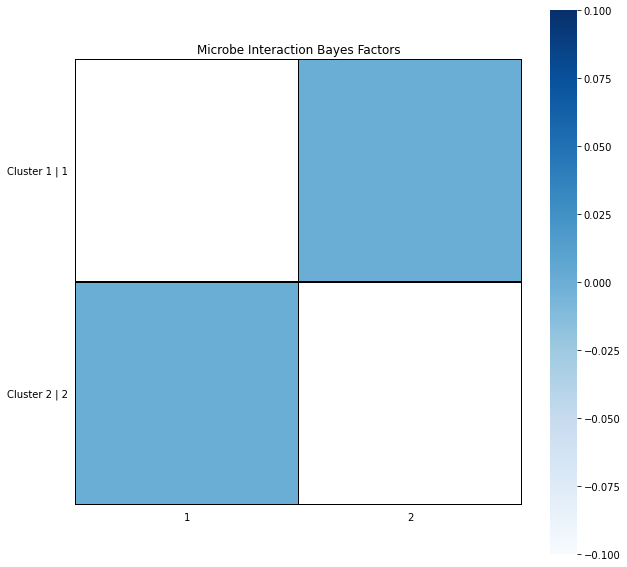

In [ ]:
# Plot bayes factors for module-module interactions
clustering = mcmc.graph[STRNAMES.CLUSTERING_OBJ]
bf_taxa = md2.generate_interation_bayes_factors_posthoc(mcmc)
bf_clustering = md2.condense_fixed_clustering_interaction_matrix(bf_taxa, clustering=clustering)

labels = ['Cluster {} | {}'.format(i+1, i+1) for i in range(len(clustering))]
md2.visualization.render_bayes_factors(bf_clustering, yticklabels=labels)
plt.savefig(fig_dir / 'posterior_fix_assignments_{:04d}.png'.format(seed))